In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights, ConvNeXt_Tiny_Weights
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
from typing import Dict
from torchvision.models import wide_resnet50_2, Wide_ResNet50_2_Weights
import shutil

In [22]:
# Data Augmentation for the training dataset
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Data Augmentation for the test dataset
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
train_dataset = datasets.ImageFolder(root='data/pellis_training/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='data/pellis_training/test', transform=test_transforms)

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Caminho para o diretório de treino
train_dir_path = Path('/kaggle/input/dataset-original/pellis_training/train')

# Lista de imagens no diretório de treino
train_images = list(train_dir_path.rglob('*/*.jpg'))

# Seleciona uma imagem aleatoriamente
img_path = np.random.choice(train_images)

# Carrega a imagem
img = Image.open(img_path)

# Obtendo o nome da classe
class_name = img_path.parent.name

# Exibe a imagem
plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Caminho para o diretório de treino
test_dir_path = Path('/kaggle/input/dataset-original/pellis_training/test')

# Lista de imagens no diretório de treino
test_images = list(test_dir_path.rglob('*/*.jpg'))

# Seleciona uma imagem aleatoriamente
img_path = np.random.choice(test_images)

# Carrega a imagem
img = Image.open(img_path)

# Obtendo o nome da classe
class_name = img_path.parent.name

# Exibe a imagem
plt.imshow(img)
plt.title(class_name)
plt.axis('off')
plt.show()


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
img_array = np.array(img)

# Plotting with matplotlib
plt.imshow(img_array)
plt.title(f'Image class: {class_name} | Image shape: {img_array.shape} -> (H, W, C)')
plt.axis('off')

In [ ]:
# Testing transforms on the image
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f'Original Image | {img_array.shape} -> (H, W, C)')

# Apply transforms
img_tensor = train_transforms(img)
img_tensor = img_tensor.numpy().transpose((1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(img_tensor)
plt.axis('off')
plt.title(f'Transformed Image | {img_tensor.shape} -> (H, W, C)')
plt.show()

In [32]:
# Getting class names from the training dataset as a list
class_names = train_dataset.classes

class_names

['1', '2 profundo', '2 superficial', '3', 'Não queimadura']

In [33]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Cria os carregadores de dados
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         pin_memory=True)

# Inspecionar os rótulos no DataLoader
for images, labels in train_loader:
    unique_labels = set(labels.cpu().numpy())
    print(f"Unique labels in train_loader: {unique_labels}")
    break

for images, labels in test_loader:
    unique_labels = set(labels.cpu().numpy())
    print(f"Unique labels in test_loader: {unique_labels}")
    break

print(f"Number of classes in train_dataset: {len(train_dataset.classes)}")
print(f"Class names: {train_dataset.classes}")

Unique labels in train_loader: {0, 1, 2, 3, 4}
Unique labels in test_loader: {0}
Number of classes in train_dataset: 5
Class names: ['1', '2 profundo', '2 superficial', '3', 'Não queimadura']


In [34]:
# Getting first batch of data
img, label = next(iter(train_loader))

# Checking the shape of the image and label
img.shape, label.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [35]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

# Carrega os pesos do ImageNet
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1

# Inicializa o modelo com os pesos
model = convnext_tiny(weights=weights)


In [36]:

# Congelar as camadas da ResNet50
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier[-1].in_features
num_classes = len(train_dataset.classes)

class ModifiedConvNext(nn.Module):
    def __init__(self, base_model, num_classes):
        super(ModifiedConvNext, self).__init__()
        self.base_model = base_model
        self.base_model.classifier = nn.Identity()  # Remove the original classifier
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),  # 3 classes para queimaduras de grau 1, 2 e 3
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x



In [37]:

class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Outras camadas do teu modelo
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(196608, 512)  # Ajusta esse valor conforme necessário
        self.fc2 = nn.Linear(512, num_classes)  # num_classes é o número de classes que você tem

    def forward(self, x):
        # Passa por outras camadas do teu modelo
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x


In [39]:
import torch 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = ModifiedConvNext(model, num_classes).to(device)


In [40]:
def train_step(model: nn.Module,
               dataloader: DataLoader,
               loss_fn: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device) -> Dict[str, float]:
    # Assuring that the model is in device (GPU or CPU)
    model.to(device)

    # Set the model to train mode
    model.train()

    # Initialize loss and metrics
    train_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_preds, all_labels = [], []

    # Looping through the dataloader
    for images, labels in dataloader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate the accuracy
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data).item()
        total_predictions += len(preds)

        # Collect predictions and labels for metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate the average loss and accuracy
    train_loss /= len(dataloader)
    train_accuracy = correct_predictions / total_predictions

    # Calculate precision, recall, and F1 score
    train_precision = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    train_f1 = f1_score(all_labels, all_preds, average='macro')

    return {
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1
    }

In [41]:
def testing_step(model: nn.Module,
                 dataloader: DataLoader,
                 loss_fn: nn.Module,
                 device: torch.device) -> Dict[str, float]:
    # Assuring that the model is in device (GPU or CPU)
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Initialize loss and metrics
    test_loss, correct_predictions, total_predictions = 0.0, 0, 0
    all_preds, all_labels = [], []

    # Looping through the dataloader
    with torch.inference_mode():
        for images, labels in dataloader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Calculate the accuracy
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data).item()
            total_predictions += len(preds)

            # Collect predictions and labels for metrics
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the average loss and accuracy
    test_loss /= len(dataloader)
    test_accuracy = correct_predictions / total_predictions

    # Calculate precision, recall, and F1 score
    test_precision = precision_score(all_labels, all_preds, average='macro')
    test_recall = recall_score(all_labels, all_preds, average='macro')
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    return {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }

In [42]:
def training(model: nn.Module,
             train_loader: DataLoader,
             test_loader: DataLoader,
             loss_fn: nn.Module,
             optimizer: optim.Optimizer,
             device: torch.device,
             num_epochs: int) -> Dict[str, float]:
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'test_loss': [],
        'test_accuracy': [],
        'test_precision': [],
        'test_recall': [],
        'test_f1': []
    }

    for epoch in tqdm(range(num_epochs)):
        train_results = train_step(model, train_loader, loss_fn, optimizer, device)
        test_results = testing_step(model, test_loader, loss_fn, device)
        
        history['train_loss'].append(train_results['train_loss'])
        history['train_accuracy'].append(train_results['train_accuracy'])
        history['train_precision'].append(train_results['train_precision'])
        history['train_recall'].append(train_results['train_recall'])
        history['train_f1'].append(train_results['train_f1'])
        
        history['test_loss'].append(test_results['test_loss'])
        history['test_accuracy'].append(test_results['test_accuracy'])
        history['test_precision'].append(test_results['test_precision'])
        history['test_recall'].append(test_results['test_recall'])
        history['test_f1'].append(test_results['test_f1'])
        
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 20)
        print(f"""
              Train Loss: {train_results['train_loss']:.4f}, 
              Train Accuracy: {train_results['train_accuracy']:.4f},
              Train Precision: {train_results['train_precision']:.4f}, 
              Train Recall: {train_results['train_recall']:.4f}, 
              Train F1: {train_results['train_f1']:.4f}
          """)
        print(f"""
              Test Loss: {test_results['test_loss']:.4f}, 
              Test Accuracy: {test_results['test_accuracy']:.4f}, 
              Test Precision: {test_results['test_precision']:.4f}, 
              Test Recall: {test_results['test_recall']:.4f}, 
              Test F1: {test_results['test_f1']:.4f}
          """)
        print()

    return history

In [43]:
for images, labels in train_loader:
    print(images.shape)
    break


torch.Size([32, 3, 256, 256])


In [44]:
import torch
import torch.nn as nn  # Importa o módulo nn aqui
import torch.optim as optim
from tqdm import tqdm


# Define a função de perda
loss_fn = nn.CrossEntropyLoss()

# Adiciona isso no começo do código, junto com as outras importações
from time import time

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
NUM_EPOCHS = 30
start_time = time()
model_results = training(model, train_loader, test_loader, loss_fn, optimizer, device, NUM_EPOCHS)
end_time = time()

total_time = end_time - start_time
print(f'Total training time: {total_time // 60:.0f}m {total_time % 60:.0f}s')
print("Training results: ", model_results)


  3%|█▏                                 | 1/30 [01:00<29:23, 60.82s/it]

Epoch 1/30
--------------------

              Train Loss: 1.2843, 
              Train Accuracy: 0.4794,
              Train Precision: 0.4128, 
              Train Recall: 0.2903, 
              Train F1: 0.2742
          

              Test Loss: 1.0817, 
              Test Accuracy: 0.5118, 
              Test Precision: 0.4632, 
              Test Recall: 0.3813, 
              Test F1: 0.3678
          



  7%|██▎                                | 2/30 [01:59<27:43, 59.41s/it]

Epoch 2/30
--------------------

              Train Loss: 0.9953, 
              Train Accuracy: 0.5946,
              Train Precision: 0.5663, 
              Train Recall: 0.5174, 
              Train F1: 0.5291
          

              Test Loss: 1.0298, 
              Test Accuracy: 0.5453, 
              Test Precision: 0.5313, 
              Test Recall: 0.4205, 
              Test F1: 0.4210
          



 10%|███▌                               | 3/30 [02:57<26:34, 59.05s/it]

Epoch 3/30
--------------------

              Train Loss: 0.8895, 
              Train Accuracy: 0.6304,
              Train Precision: 0.6125, 
              Train Recall: 0.5687, 
              Train F1: 0.5824
          

              Test Loss: 0.9510, 
              Test Accuracy: 0.6240, 
              Test Precision: 0.5779, 
              Test Recall: 0.5993, 
              Test F1: 0.5855
          



 13%|████▋                              | 4/30 [03:55<25:25, 58.69s/it]

Epoch 4/30
--------------------

              Train Loss: 0.8008, 
              Train Accuracy: 0.6701,
              Train Precision: 0.6561, 
              Train Recall: 0.6269, 
              Train F1: 0.6370
          

              Test Loss: 0.9182, 
              Test Accuracy: 0.6516, 
              Test Precision: 0.6240, 
              Test Recall: 0.5776, 
              Test F1: 0.5962
          



 17%|█████▊                             | 5/30 [04:54<24:26, 58.67s/it]

Epoch 5/30
--------------------

              Train Loss: 0.7239, 
              Train Accuracy: 0.7069,
              Train Precision: 0.6961, 
              Train Recall: 0.6722, 
              Train F1: 0.6822
          

              Test Loss: 0.9314, 
              Test Accuracy: 0.6339, 
              Test Precision: 0.6077, 
              Test Recall: 0.5866, 
              Test F1: 0.5886
          



 20%|███████                            | 6/30 [05:52<23:22, 58.42s/it]

Epoch 6/30
--------------------

              Train Loss: 0.6756, 
              Train Accuracy: 0.7293,
              Train Precision: 0.7211, 
              Train Recall: 0.6964, 
              Train F1: 0.7076
          

              Test Loss: 0.9721, 
              Test Accuracy: 0.6358, 
              Test Precision: 0.6216, 
              Test Recall: 0.5647, 
              Test F1: 0.5723
          



 23%|████████▏                          | 7/30 [06:50<22:20, 58.28s/it]

Epoch 7/30
--------------------

              Train Loss: 0.5996, 
              Train Accuracy: 0.7645,
              Train Precision: 0.7688, 
              Train Recall: 0.7345, 
              Train F1: 0.7498
          

              Test Loss: 0.9502, 
              Test Accuracy: 0.6594, 
              Test Precision: 0.6157, 
              Test Recall: 0.6128, 
              Test F1: 0.6084
          



 27%|█████████▎                         | 8/30 [07:48<21:21, 58.27s/it]

Epoch 8/30
--------------------

              Train Loss: 0.5438, 
              Train Accuracy: 0.7854,
              Train Precision: 0.7830, 
              Train Recall: 0.7672, 
              Train F1: 0.7741
          

              Test Loss: 0.9769, 
              Test Accuracy: 0.6398, 
              Test Precision: 0.6032, 
              Test Recall: 0.5924, 
              Test F1: 0.5936
          



 30%|██████████▌                        | 9/30 [08:47<20:25, 58.37s/it]

Epoch 9/30
--------------------

              Train Loss: 0.4703, 
              Train Accuracy: 0.8301,
              Train Precision: 0.8363, 
              Train Recall: 0.8173, 
              Train F1: 0.8262
          

              Test Loss: 1.0924, 
              Test Accuracy: 0.6220, 
              Test Precision: 0.5781, 
              Test Recall: 0.5833, 
              Test F1: 0.5691
          



 33%|███████████▎                      | 10/30 [09:45<19:25, 58.26s/it]

Epoch 10/30
--------------------

              Train Loss: 0.4108, 
              Train Accuracy: 0.8420,
              Train Precision: 0.8436, 
              Train Recall: 0.8269, 
              Train F1: 0.8347
          

              Test Loss: 1.1086, 
              Test Accuracy: 0.6555, 
              Test Precision: 0.6063, 
              Test Recall: 0.6007, 
              Test F1: 0.5930
          



 37%|████████████▍                     | 11/30 [10:43<18:26, 58.26s/it]

Epoch 11/30
--------------------

              Train Loss: 0.3758, 
              Train Accuracy: 0.8544,
              Train Precision: 0.8508, 
              Train Recall: 0.8415, 
              Train F1: 0.8459
          

              Test Loss: 1.1541, 
              Test Accuracy: 0.6181, 
              Test Precision: 0.5841, 
              Test Recall: 0.5846, 
              Test F1: 0.5786
          



 40%|█████████████▌                    | 12/30 [11:41<17:27, 58.19s/it]

Epoch 12/30
--------------------

              Train Loss: 0.3027, 
              Train Accuracy: 0.8897,
              Train Precision: 0.8921, 
              Train Recall: 0.8779, 
              Train F1: 0.8847
          

              Test Loss: 1.2408, 
              Test Accuracy: 0.6398, 
              Test Precision: 0.6031, 
              Test Recall: 0.5827, 
              Test F1: 0.5795
          



 43%|██████████████▋                   | 13/30 [12:39<16:27, 58.08s/it]

Epoch 13/30
--------------------

              Train Loss: 0.3050, 
              Train Accuracy: 0.8897,
              Train Precision: 0.8918, 
              Train Recall: 0.8776, 
              Train F1: 0.8843
          

              Test Loss: 1.2929, 
              Test Accuracy: 0.6102, 
              Test Precision: 0.5758, 
              Test Recall: 0.6175, 
              Test F1: 0.5893
          



 47%|███████████████▊                  | 14/30 [13:37<15:30, 58.17s/it]

Epoch 14/30
--------------------

              Train Loss: 0.2743, 
              Train Accuracy: 0.8967,
              Train Precision: 0.8982, 
              Train Recall: 0.8905, 
              Train F1: 0.8943
          

              Test Loss: 1.2823, 
              Test Accuracy: 0.6398, 
              Test Precision: 0.6111, 
              Test Recall: 0.6233, 
              Test F1: 0.6104
          



 50%|█████████████████                 | 15/30 [14:35<14:32, 58.14s/it]

Epoch 15/30
--------------------

              Train Loss: 0.2446, 
              Train Accuracy: 0.9121,
              Train Precision: 0.9143, 
              Train Recall: 0.9072, 
              Train F1: 0.9107
          

              Test Loss: 1.3617, 
              Test Accuracy: 0.6181, 
              Test Precision: 0.5802, 
              Test Recall: 0.5507, 
              Test F1: 0.5578
          



 53%|██████████████████▏               | 16/30 [15:34<13:35, 58.25s/it]

Epoch 16/30
--------------------

              Train Loss: 0.2207, 
              Train Accuracy: 0.9175,
              Train Precision: 0.9153, 
              Train Recall: 0.9104, 
              Train F1: 0.9128
          

              Test Loss: 1.4294, 
              Test Accuracy: 0.6181, 
              Test Precision: 0.5793, 
              Test Recall: 0.5943, 
              Test F1: 0.5794
          



 57%|███████████████████▎              | 17/30 [16:32<12:36, 58.19s/it]

Epoch 17/30
--------------------

              Train Loss: 0.2060, 
              Train Accuracy: 0.9275,
              Train Precision: 0.9273, 
              Train Recall: 0.9199, 
              Train F1: 0.9234
          

              Test Loss: 1.4703, 
              Test Accuracy: 0.6122, 
              Test Precision: 0.5526, 
              Test Recall: 0.5536, 
              Test F1: 0.5486
          



 60%|████████████████████▍             | 18/30 [17:30<11:38, 58.23s/it]

Epoch 18/30
--------------------

              Train Loss: 0.2006, 
              Train Accuracy: 0.9280,
              Train Precision: 0.9302, 
              Train Recall: 0.9275, 
              Train F1: 0.9287
          

              Test Loss: 1.6165, 
              Test Accuracy: 0.6024, 
              Test Precision: 0.5753, 
              Test Recall: 0.5329, 
              Test F1: 0.5394
          



 63%|█████████████████████▌            | 19/30 [18:28<10:39, 58.12s/it]

Epoch 19/30
--------------------

              Train Loss: 0.1951, 
              Train Accuracy: 0.9344,
              Train Precision: 0.9341, 
              Train Recall: 0.9278, 
              Train F1: 0.9309
          

              Test Loss: 1.4277, 
              Test Accuracy: 0.6358, 
              Test Precision: 0.5837, 
              Test Recall: 0.5646, 
              Test F1: 0.5692
          



 67%|██████████████████████▋           | 20/30 [19:26<09:40, 58.03s/it]

Epoch 20/30
--------------------

              Train Loss: 0.1788, 
              Train Accuracy: 0.9384,
              Train Precision: 0.9372, 
              Train Recall: 0.9326, 
              Train F1: 0.9348
          

              Test Loss: 1.5138, 
              Test Accuracy: 0.6102, 
              Test Precision: 0.5686, 
              Test Recall: 0.5606, 
              Test F1: 0.5574
          



 70%|███████████████████████▊          | 21/30 [20:24<08:42, 58.07s/it]

Epoch 21/30
--------------------

              Train Loss: 0.1616, 
              Train Accuracy: 0.9449,
              Train Precision: 0.9428, 
              Train Recall: 0.9397, 
              Train F1: 0.9413
          

              Test Loss: 1.4666, 
              Test Accuracy: 0.6378, 
              Test Precision: 0.5844, 
              Test Recall: 0.5991, 
              Test F1: 0.5862
          



 73%|████████████████████████▉         | 22/30 [21:22<07:44, 58.10s/it]

Epoch 22/30
--------------------

              Train Loss: 0.1475, 
              Train Accuracy: 0.9543,
              Train Precision: 0.9568, 
              Train Recall: 0.9529, 
              Train F1: 0.9548
          

              Test Loss: 1.5952, 
              Test Accuracy: 0.6339, 
              Test Precision: 0.5847, 
              Test Recall: 0.5913, 
              Test F1: 0.5838
          



 77%|██████████████████████████        | 23/30 [22:21<06:46, 58.14s/it]

Epoch 23/30
--------------------

              Train Loss: 0.1622, 
              Train Accuracy: 0.9429,
              Train Precision: 0.9415, 
              Train Recall: 0.9355, 
              Train F1: 0.9385
          

              Test Loss: 1.6142, 
              Test Accuracy: 0.6319, 
              Test Precision: 0.5958, 
              Test Recall: 0.5870, 
              Test F1: 0.5752
          



 80%|███████████████████████████▏      | 24/30 [23:19<05:49, 58.24s/it]

Epoch 24/30
--------------------

              Train Loss: 0.1313, 
              Train Accuracy: 0.9553,
              Train Precision: 0.9553, 
              Train Recall: 0.9534, 
              Train F1: 0.9543
          

              Test Loss: 1.7375, 
              Test Accuracy: 0.6319, 
              Test Precision: 0.5989, 
              Test Recall: 0.5697, 
              Test F1: 0.5639
          



 83%|████████████████████████████▎     | 25/30 [24:18<04:51, 58.32s/it]

Epoch 25/30
--------------------

              Train Loss: 0.1335, 
              Train Accuracy: 0.9548,
              Train Precision: 0.9559, 
              Train Recall: 0.9510, 
              Train F1: 0.9534
          

              Test Loss: 1.7498, 
              Test Accuracy: 0.5846, 
              Test Precision: 0.5313, 
              Test Recall: 0.5443, 
              Test F1: 0.5286
          



 87%|█████████████████████████████▍    | 26/30 [25:16<03:53, 58.32s/it]

Epoch 26/30
--------------------

              Train Loss: 0.1177, 
              Train Accuracy: 0.9617,
              Train Precision: 0.9600, 
              Train Recall: 0.9584, 
              Train F1: 0.9592
          

              Test Loss: 1.7511, 
              Test Accuracy: 0.5925, 
              Test Precision: 0.5460, 
              Test Recall: 0.5426, 
              Test F1: 0.5386
          



 90%|██████████████████████████████▌   | 27/30 [26:14<02:54, 58.25s/it]

Epoch 27/30
--------------------

              Train Loss: 0.1114, 
              Train Accuracy: 0.9677,
              Train Precision: 0.9709, 
              Train Recall: 0.9656, 
              Train F1: 0.9682
          

              Test Loss: 1.6710, 
              Test Accuracy: 0.6339, 
              Test Precision: 0.5781, 
              Test Recall: 0.5697, 
              Test F1: 0.5715
          



 93%|███████████████████████████████▋  | 28/30 [27:12<01:56, 58.16s/it]

Epoch 28/30
--------------------

              Train Loss: 0.1039, 
              Train Accuracy: 0.9657,
              Train Precision: 0.9654, 
              Train Recall: 0.9609, 
              Train F1: 0.9631
          

              Test Loss: 1.7854, 
              Test Accuracy: 0.6220, 
              Test Precision: 0.5781, 
              Test Recall: 0.5662, 
              Test F1: 0.5602
          



 97%|████████████████████████████████▊ | 29/30 [28:10<00:58, 58.27s/it]

Epoch 29/30
--------------------

              Train Loss: 0.1203, 
              Train Accuracy: 0.9578,
              Train Precision: 0.9616, 
              Train Recall: 0.9545, 
              Train F1: 0.9580
          

              Test Loss: 1.6678, 
              Test Accuracy: 0.6299, 
              Test Precision: 0.5849, 
              Test Recall: 0.5969, 
              Test F1: 0.5861
          



100%|██████████████████████████████████| 30/30 [29:09<00:00, 58.30s/it]

Epoch 30/30
--------------------

              Train Loss: 0.1174, 
              Train Accuracy: 0.9553,
              Train Precision: 0.9552, 
              Train Recall: 0.9548, 
              Train F1: 0.9550
          

              Test Loss: 1.7773, 
              Test Accuracy: 0.6083, 
              Test Precision: 0.5724, 
              Test Recall: 0.5929, 
              Test F1: 0.5710
          

Total training time: 29m 9s
Training results:  {'train_loss': [1.2842923885300046, 0.9953091163483877, 0.8895095142107161, 0.8008279166524372, 0.7238552102020809, 0.6756105976445335, 0.5995557568376026, 0.5438196928728194, 0.4702590330252572, 0.41083176008292605, 0.3757914337846968, 0.30274478121409343, 0.3049612585750837, 0.2743312982576234, 0.24455033313660396, 0.2207386452290747, 0.20600407558774192, 0.2006326350900862, 0.19508018190898593, 0.17882511268059412, 0.16162007550398508, 0.14749145419115112, 0.16220587184504856, 0.1313467597854989, 0.13352652565236128, 0.117726560

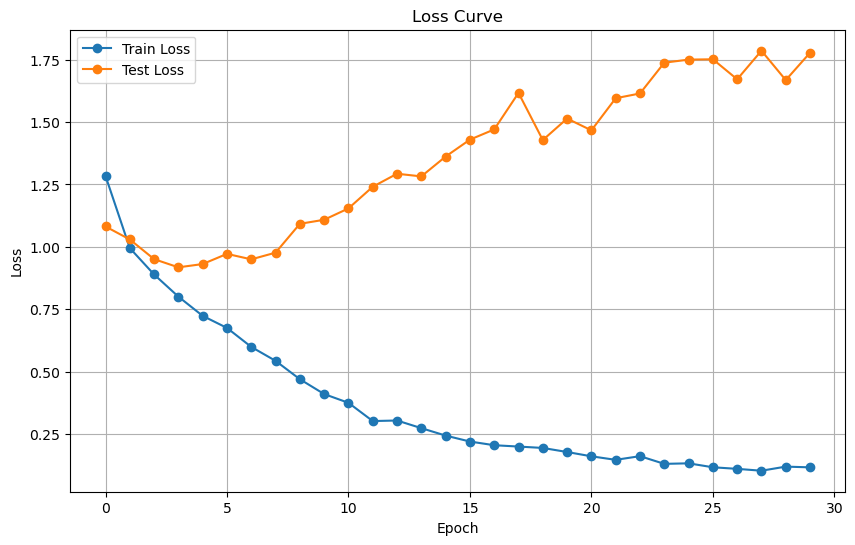

In [45]:
def plot_loss_curve(history: Dict[str, float]):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['test_loss'], label='Test Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss_curve(model_results)


In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model: nn.Module,
                          dataloader: DataLoader,
                          device: torch.device,
                          class_names: list) -> None:
    model.eval()
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for images, labels in tqdm(dataloader, desc='Predicting...'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)
    plt.title('Confusion Matrix')
    plt.show()

Predicting...: 100%|███████████████████| 16/16 [00:08<00:00,  1.82it/s]


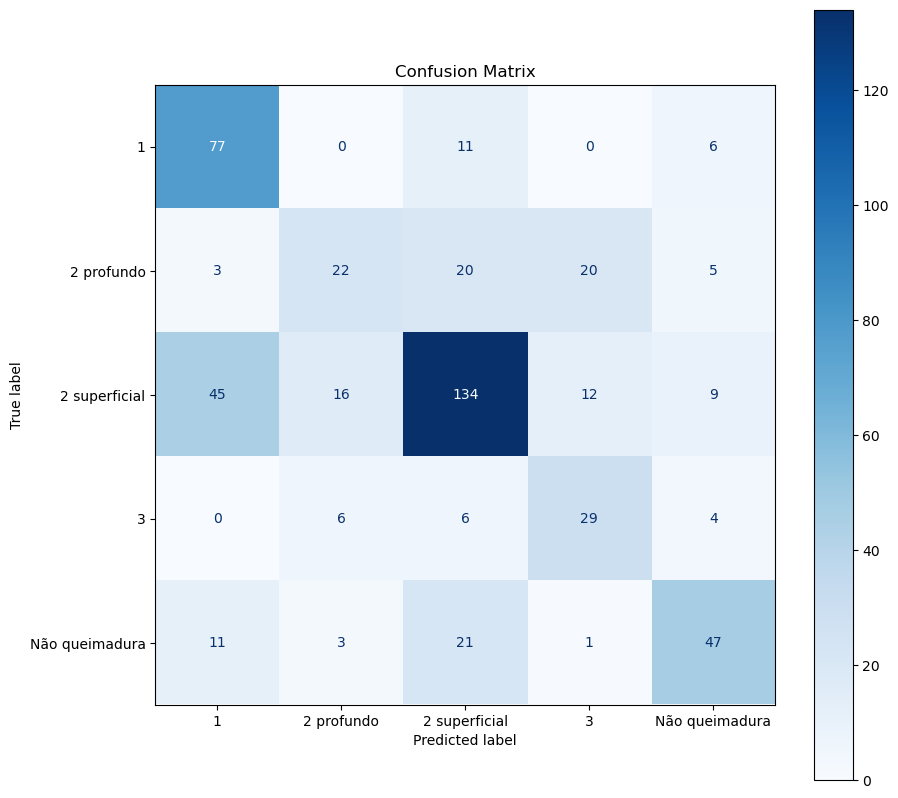

In [47]:
# Plotting the confusion matrix
plot_confusion_matrix(model, test_loader, device, class_names)